In [178]:
from VariationalBayes.Parameters import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import UVNParam, UVNParamVector
from VariationalBayes.ExponentialFamilies import UnivariateNormalEntropy, UVNPrior

import autograd
import autograd.numpy as np
import scipy as sp

import copy
from scipy import optimize

import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
def gauss_log_prob(theta, z, info_mat):
    s, logdet = np.linalg.slogdet(info_mat)
    assert(s > 0)
    return -0.5 * (info_mat[0, 0] * theta**2 + info_mat[1, 1] * z**2 + 2 * info_mat[1, 0] * theta * z) \
        + 0.5 * logdet

def banana_log_prob(theta_exp, z, info_mat, include_jacobian=True):
    theta = np.log(theta_exp)
    return gauss_log_prob(theta, z, info_mat) - include_jacobian * theta 


In [162]:
corr = 0.95 # The correlation
ellipticity = 1.0 # The ratio of the theta scale to the z scale
scale = 0.6 # The overall scale
assert(np.abs(corr) < 1)
assert(ellipticity > 0)
cov_scale = scale * np.diag([1.0, ellipticity])
corr_mat = np.eye(2)
corr_mat[0, 1] = corr_mat[1, 0] = corr
cov_mat = np.matmul(cov_scale, np.matmul(corr_mat, cov_scale)) 
info_mat = np.linalg.inv(cov_mat)

print(cov_mat)

[[ 0.36   0.342]
 [ 0.342  0.36 ]]


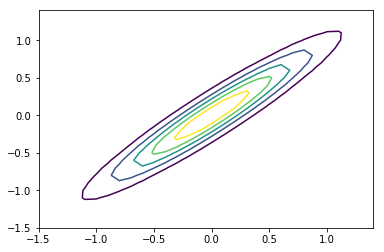

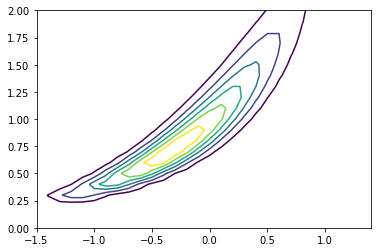

In [163]:
grid_points = np.arange(-2.5 * scale, 2.5 * scale, 0.1)
theta_grid, z_grid = np.meshgrid(grid_points, grid_points)
grid_points_b = np.arange(0.000001, np.exp(1.2 * scale), 0.1)
theta_b_grid, z_b_grid = np.meshgrid(grid_points_b, grid_points)

glp = gauss_log_prob(theta_grid, z_grid, info_mat)
blp = banana_log_prob(theta_b_grid, z_b_grid, info_mat)

plt.figure()
plt.contour(z_grid, theta_grid, np.exp(glp))

plt.figure()
plt.contour(z_b_grid, theta_b_grid, np.exp(blp))


1.19806655518
1.19721736312


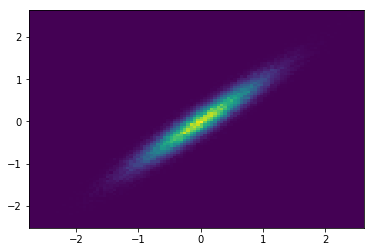

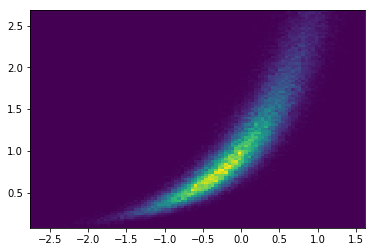

In [170]:
num_draws = int(1e5)
draws = np.random.multivariate_normal(np.array([0., 0.]), cov_mat, num_draws)
theta_draws = draws[:, 0]
exp_theta_draws = np.exp(theta_draws)
z_draws = draws[:, 1]

plt.figure()
plt.hist2d(z_draws, theta_draws, bins=100);

plt.figure()
keep_rows = exp_theta_draws < np.percentile(exp_theta_draws, 95)
plt.hist2d(z_draws[keep_rows], exp_theta_draws[keep_rows], bins=100);


In [194]:
def gauss_log_prob_wrapper(par):
    return -1 * gauss_log_prob(par[0], par[1], info_mat)

def banana_log_prob_wrapper(par, include_jacobian=True):
    if par[0] <= 0:
        return float('inf')
    return -1 * banana_log_prob(par[0], par[1], info_mat, include_jacobian=include_jacobian)

glp_opt = sp.optimize.minimize(gauss_log_prob_wrapper, method='Nelder-Mead', x0=[0.1, 0.2])
print(glp_opt.x)

blp_opt = sp.optimize.minimize(banana_log_prob_wrapper, method='Nelder-Mead', x0=[1.0, 0.2])
print(blp_opt.x)

# Note that the Jacobian means the MAP isn't invariant to reparameterizations.
blp_no_jac_opt = \
    sp.optimize.minimize(lambda par: banana_log_prob_wrapper(par, include_jacobian=False), 
                         method='Nelder-Mead', x0=[1.0, 0.2])
print(blp_no_jac_opt.x)


banana_log_prob_wrapper_hessian = autograd.hessian(banana_log_prob_wrapper)
blp_hess = banana_log_prob_wrapper_hessian(blp_opt.x)
blp_hess_cov = np.linalg.inv(blp_hess)

gauss_log_prob_wrapper_hessian = autograd.hessian(gauss_log_prob_wrapper)
glp_hess = gauss_log_prob_wrapper_hessian(glp_opt.x)
glp_hess_cov = np.linalg.inv(glp_hess)

print(glp_hess_cov)
print(cov_mat)

[ -4.01311861e-05  -3.23342060e-05]
[ 0.69760143 -0.34208864]
[  1.00001552e+00  -1.97567073e-06]
[[ 0.36   0.342]
 [ 0.342  0.36 ]]
[[ 0.36   0.342]
 [ 0.342  0.36 ]]


In this case, we know that the distribution of $\exp(\theta)$ is lognormal, so

$$
P(\theta) = \mathcal{N}(0, V_\theta)\\
\mathbb{E}[\exp(\theta)] = \exp\left(\frac{V_\theta ^ 2}{2} \right)\\
\mathrm{Var}(\exp(\theta)) = \left(\exp(V_\theta ^ 2) - 1 \right) \exp(V_\theta ^ 2)
$$

In [190]:

print("True mean:\t\t", np.exp(0.5 * cov_mat[0, 0]))
print("Sample mean:\t\t", np.mean(exp_theta_draws))
print("MAP estimate:\t\t", blp_opt.x[0])

print('\n')
print('True var:\t\t', (np.exp(cov_mat[0, 0]) - 1) * np.exp(cov_mat[0, 0]))
print('Sample var:\t\t', np.var(exp_theta_draws))
print('MAP var:\t\t', blp_hess_cov[0, 0])


Sample mean:		 1.19806655518
True mean:		 1.19721736312
MAP estimate:		 0.697601425656


True var:		 0.621103796084
Sample var:		 0.622591269044
MAP var:		 0.175151590973
